In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib
import sys

import glob

In [5]:
def hf(img_list) :

    hf_dataset = []

    for img in img_list:
        img = cv2.imread(img)
        img = cv2.resize(img, (256, 256))
        
        ### homomorphic filter는 gray scale image에 대해서 밖에 안 되므로
        ### YUV color space로 converting한 뒤 Y에 대해 연산을 진행
        img_YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        y = img_YUV[:,:,0]

        rows = y.shape[0]
        cols = y.shape[1]

        ### illumination elements와 reflectance elements를 분리하기 위해 log를 취함
        imgLog = np.log1p(np.array(y, dtype='float') / 255) # y값을 0~1사이로 조정한 뒤 log(x+1)

        ### frequency를 이미지로 나타내면 4분면에 대칭적으로 나타나므로
        ### 4분면 중 하나에 이미지를 대응시키기 위해 row와 column을 2배씩 늘려줌
        M = 2*rows + 1
        N = 2*cols + 1

        ### gaussian mask 생성 sigma = 10
        sigma = 10
        (X, Y) = np.meshgrid(np.linspace(0, N-1, N), np.linspace(0, M-1, M)) # 0~N-1(and M-1) 까지 1단위로 space를 만듬
        Xc = np.ceil(N/2) # 올림 연산
        Yc = np.ceil(M/2)
        gaussianNumerator = (X - Xc)**2 + (Y - Yc)**2 # 가우시안 분자 생성

        ### low pass filter와 high pass filter 생성
        LPF = np.exp(-gaussianNumerator / (2*sigma*sigma))
        HPF = 1 - LPF

        ### LPF랑 HPF를 0이 가운데로 오도록iFFT함.
        ### 사실 이 부분이 잘 이해가 안 가는데 plt로 이미지를 띄워보니 shuffling을 수행한 효과가 났음
        ### 에너지를 각 귀퉁이로 모아 줌
        LPF_shift = np.fft.ifftshift(LPF.copy())
        HPF_shift = np.fft.ifftshift(HPF.copy())

        ### Log를 씌운 이미지를 FFT해서 LPF와 HPF를 곱해 LF성분과 HF성분을 나눔
        img_FFT = np.fft.fft2(imgLog.copy(), (M, N))
        img_LF = np.real(np.fft.ifft2(img_FFT.copy() * LPF_shift, (M, N))) # low frequency 성분
        img_HF = np.real(np.fft.ifft2(img_FFT.copy() * HPF_shift, (M, N))) # high frequency 성분

        ### 각 LF, HF 성분에 scaling factor를 곱해주어 조명값과 반사값을 조절함
        gamma1 = 0.3
        gamma2 = 1.5
        img_adjusting = gamma1*img_LF[0:rows, 0:cols] + gamma2*img_HF[0:rows, 0:cols]

        ### 조정된 데이터를 이제 exp 연산을 통해 이미지로 만들어줌
        img_exp = np.expm1(img_adjusting) # exp(x) + 1
        img_exp = (img_exp - np.min(img_exp)) / (np.max(img_exp) - np.min(img_exp)) # 0~1사이로 정규화
        img_out = np.array(255*img_exp, dtype = 'uint8') # 255를 곱해서 intensity값을 만들어줌

        ### 마지막으로 YUV에서 Y space를 filtering된 이미지로 교체해주고 RGB space로 converting
        img_YUV[:,:,0] = img_out
        result = cv2.cvtColor(img_YUV, cv2.COLOR_YUV2BGR)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        hf_dataset.append(result)
    
    return hf_dataset

### BUSI

In [2]:
li = glob.glob('/dshome/ddualab/seonjin2/denosing/dataset/BUSI/*')

img_list = []

for i in li :
    
    img = glob.glob(i + '/*).png')
    img_list.extend(img)

In [3]:
origin_dataset = []

for img in img_list:
    
  img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

  resized_img = cv2.resize(img, (256, 256))
  origin_dataset.append(resized_img)

origin_dataset = np.array(origin_dataset)


origin_dataset = origin_dataset.reshape(origin_dataset.shape[0], -1)

x = origin_dataset.mean(axis=1)
x = np.float32(x)

In [6]:
norm_dataset = hf(img_list)

norm_dataset = np.array(norm_dataset)

norm_dataset = norm_dataset.reshape(origin_dataset.shape[0], -1)

y = norm_dataset.mean(axis=1)
y = np.float32(y)

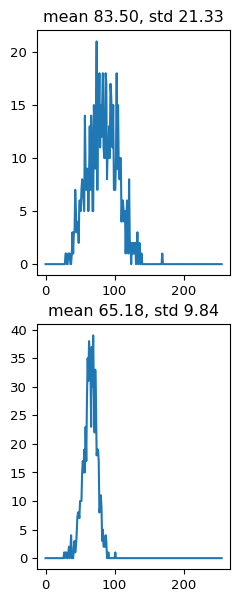

In [8]:
font = {'size'   : 9.5}

plt.rc('font', **font)


plt.figure(figsize=(2.5,7))
 

for i, hist in enumerate([x,y]) :
    
    plt.subplot(2,1,i+1)
    be_hist = cv2.calcHist([hist], [0], None, [256], [0, 256])
    plt.plot(be_hist)
    
    
    #plt.subtitle('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
   
    plt.title('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
    

### B

In [9]:
li = glob.glob('/dshome/ddualab/seonjin2/denosing/dataset/Dataset B/original')

img_list = []

for i in li :
    
    img = glob.glob(i + '/*.png')
    img_list.extend(img)

In [10]:
origin_dataset = []

for img in img_list:
    
  img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

  resized_img = cv2.resize(img, (256, 256))
  origin_dataset.append(resized_img)

origin_dataset = np.array(origin_dataset)


origin_dataset = origin_dataset.reshape(origin_dataset.shape[0], -1)

x = origin_dataset.mean(axis=1)
x = np.float32(x)
len(x)

163

In [11]:
norm_dataset = hf(img_list)

norm_dataset = np.array(norm_dataset)

norm_dataset = norm_dataset.reshape(origin_dataset.shape[0], -1)

y = norm_dataset.mean(axis=1)
y = np.float32(y)

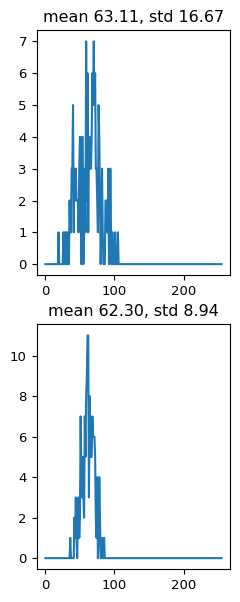

In [12]:
font = {'size'   : 9.5}

plt.rc('font', **font)


plt.figure(figsize=(2.5,7))
 

for i, hist in enumerate([x,y]) :
    
    plt.subplot(2,1,i+1)
    be_hist = cv2.calcHist([hist], [0], None, [256], [0, 256])
    plt.plot(be_hist)
    
    
    #plt.subtitle('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
   
    plt.title('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
    

### NEW dataset

In [13]:
li = glob.glob('/dshome/ddualab/seonjin2/denosing/dataset/Miccai BUV/*/*')

img_list = []

for i in li :
    
    img = glob.glob(i + '/*.png')
    img_list.extend(img)

In [14]:
len(img_list)

1000

In [15]:
origin_dataset = []

for img in img_list:
    
  img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

  resized_img = cv2.resize(img, (256, 256))
  origin_dataset.append(resized_img)

origin_dataset = np.array(origin_dataset)


origin_dataset = origin_dataset.reshape(origin_dataset.shape[0], -1)

x = origin_dataset.mean(axis=1)
x = np.float32(x)
len(x)

1000

In [16]:
norm_dataset = hf(img_list)

norm_dataset = np.array(norm_dataset)

norm_dataset = norm_dataset.reshape(origin_dataset.shape[0], -1)

y = norm_dataset.mean(axis=1)
y = np.float32(y)

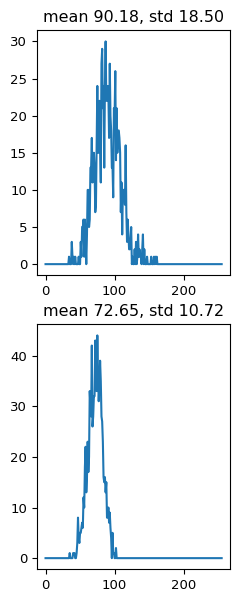

In [17]:
font = {'size'   : 9.5}

plt.rc('font', **font)


plt.figure(figsize=(2.5,7))
 

for i, hist in enumerate([x,y]) :
    
    plt.subplot(2,1,i+1)
    be_hist = cv2.calcHist([hist], [0], None, [256], [0, 256])
    plt.plot(be_hist)
    
    
    #plt.subtitle('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
   
    plt.title('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
    

### fatty liver

In [18]:
li = glob.glob('/dshome/ddualab/seonjin2/denosing/dataset/fatty liver')

img_list = []

for i in li :
    
    img = glob.glob(i + '/*.png')
    img_list.extend(img)

len(img_list)

550

In [19]:
origin_dataset = []

for img in img_list:
    
  img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

  resized_img = cv2.resize(img, (256, 256))
  origin_dataset.append(resized_img)

origin_dataset = np.array(origin_dataset)


origin_dataset = origin_dataset.reshape(origin_dataset.shape[0], -1)

x = origin_dataset.mean(axis=1)
x = np.float32(x)
len(x)

550

In [20]:
norm_dataset = hf(img_list)

norm_dataset = np.array(norm_dataset)

norm_dataset = norm_dataset.reshape(origin_dataset.shape[0], -1)

y = norm_dataset.mean(axis=1)
y = np.float32(y)

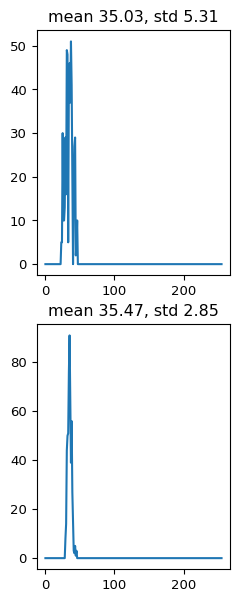

In [21]:
font = {'size'   : 9.5}

plt.rc('font', **font)


plt.figure(figsize=(2.5,7))
 

for i, hist in enumerate([x,y]) :
    
    plt.subplot(2,1,i+1)
    be_hist = cv2.calcHist([hist], [0], None, [256], [0, 256])
    plt.plot(be_hist)
    
    
    #plt.subtitle('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
   
    plt.title('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
    

### kidney

In [22]:
li = glob.glob('/dshome/ddualab/seonjin2/denosing/dataset/kidneyUS/image')

img_list = []

for i in li :
    
    img = glob.glob(i + '/*.png')
    img_list.extend(img)

len(img_list)

534

In [23]:
origin_dataset = []

for img in img_list:
    
  img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

  resized_img = cv2.resize(img, (256, 256))
  origin_dataset.append(resized_img)

origin_dataset = np.array(origin_dataset)


origin_dataset = origin_dataset.reshape(origin_dataset.shape[0], -1)

x = origin_dataset.mean(axis=1)
x = np.float32(x)
len(x)

534

In [24]:
norm_dataset = hf(img_list)

norm_dataset = np.array(norm_dataset)

norm_dataset = norm_dataset.reshape(origin_dataset.shape[0], -1)

y = norm_dataset.mean(axis=1)
y = np.float32(y)

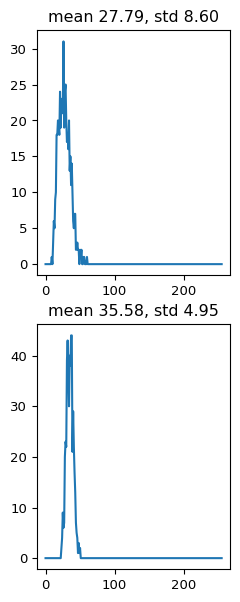

In [25]:
font = {'size'   : 9.5}

plt.rc('font', **font)


plt.figure(figsize=(2.5,7))
 

for i, hist in enumerate([x,y]) :
    
    plt.subplot(2,1,i+1)
    be_hist = cv2.calcHist([hist], [0], None, [256], [0, 256])
    plt.plot(be_hist)
    
    
    #plt.subtitle('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))
   
    plt.title('mean {:.2f}, std {:.2f}'.format(hist.mean(), hist.std()))